## Data Wrangling

In [7]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def box_plot(dataframe, col_list_float, plot_kind):
    """
    This function generates boxplots to show distribution and outliers of various parameters
    """
    
   
    x_val = 1
    y_val = len(col_list_float)
        
    if len(dataframe['model_year'].unique()) ==1:
        title_year = dataframe['model_year'].min()
    else:
        title_year = f'{dataframe["model_year"].min()} - {dataframe["model_year"].max()}'
        
    fig1, axes = plt.subplots(x_val,y_val , sharey=True, figsize=(18,6))
    
    k=0
    for i in range(0,x_val):
        for j in range(0,y_val):

            variable= col_list_float[k].lower()
            if plot_kind=="box":
                sns.boxplot(ax=axes[j], data=dataframe, x=variable)
                fig1.suptitle(f'Outlier identification by vehicle class {title_year}')
            elif plot_kind=="hist":
                sns.histplot(ax=axes[j], data=dataframe, x=variable,bins=10)
                fig1.suptitle(f'Distribution of data {title_year}')
            k+=1
    plt.show()

In [2]:
folder = 'C:/Users/Laura GF/Documents/GitHub/machine-learning-capstone/data/'
raw_data = f'{folder}raw-data/'
clean_data = f'{folder}clean-data/'

In [4]:
data_sales = pd.read_csv(Path(clean_data,"long_format_car_sales.csv" ))

In [21]:
data_sales[data_sales['number_units_sold']>7500]

,number_units_sold,make,model_,date
1068,8554,Ford,F-Series,2019-01-01
1069,8455,Ford,F-Series,2019-02-01
1070,13098,Ford,F-Series,2019-03-01
1071,13513,Ford,F-Series,2019-04-01
1072,15891,Ford,F-Series,2019-05-01
1073,15394,Ford,F-Series,2019-06-01
1074,13862,Ford,F-Series,2019-07-01
1075,14600,Ford,F-Series,2019-08-01
1076,13675,Ford,F-Series,2019-09-01
1077,10972,Ford,F-Series,2019-10-01


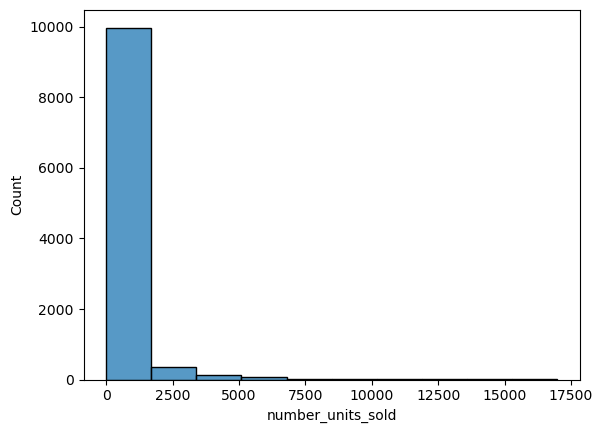

In [14]:
sns.histplot(data=data_sales, x='number_units_sold', bins=10)


### Topic: Fuel consumption ratings (Statistics Canada)

Site https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64

In [ ]:
fuel_df = pd.read_csv(Path(clean_data,"1995_2022_vehicle_fuel_consumption.csv"))

In [ ]:
fuel_df[fuel_df['make_']=="ford"]['co2_rating'].mean()

### Topic: Number of cars sold in Canada by make and model

Site: https://www.goodcarbadcar.net/


The data was extracted using Scrapy

In [ ]:
df_all_sales = pd.read_csv(Path(clean_data, "long_format_car_sales.csv"))

In [ ]:
df_all_sales

### Topic: New motor vehicle registrations, quarterly (Statistics Canada)

Site https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2010002401



### Topic: New zero-emission vehicle registrations, quarterly (Statistics Canada)

https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2010002501

### Topic: Sales of fuel used for road motor vehicles, annual (Statistics Canada)

https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2310006601

### Topic: Vehicle registrations, by type of vehicle (Statistics Canada)

https://open.canada.ca/data/en/dataset/9aea572f-f54f-42a1-b411-0b06390ed9f9